In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import torch
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import warnings

warnings.filterwarnings("ignore")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
train_dir = '..\\data\\train'
val_dir = '..\\data\\val'
test_dir = '..\\data\\test'

label_dict = {'1': 'Surprise', '2': 'Fear', '3': 'Disgust', '4': 'Happy', '5': 'Sadness', '6': 'Anger', '7': 'Neutral'}

test_transform = transforms.Compose([
    transforms.Resize((100, 100)),
    transforms.ToTensor(),  # convert image to PyTorch tensor with range [0, 1]
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # normalize image for pre-trained model (mean and std from ImageNet)
])

train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),  # Increase rotation degree
    transforms.RandomAffine(degrees=0, shear=10, scale=(0.8, 1.2)),  # Increase shear and scale range
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),  # Increase jitter parameters
    # transforms.RandomGrayscale(p=0.1),
    transforms.Resize((100, 100)),
    transforms.ToTensor(),  # Convert image to PyTorch tensor with range [0, 1]
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize image for pre-trained model (mean and std from ImageNet)
])

# Apply the transformations directly when creating the datasets
train_dataset = datasets.ImageFolder(train_dir, transform=train_transform)
val_dataset = datasets.ImageFolder(val_dir, transform=test_transform)

train_dl = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dl = DataLoader(val_dataset, batch_size=64, shuffle=False)

In [ ]:
def get_class_weights_for_unbalanced_data(dataset):
    class_count = np.bincount(dataset.targets)
    class_weights = class_count / class_count.sum()
    class_weights = torch.tensor(class_weights).to(device).float()
    class_weights = 1.0 / class_weights
    class_weights /= class_weights.sum()
    return class_weights

class_weights = get_class_weights_for_unbalanced_data(train_dataset)

tensor([0.0939, 0.4310, 0.1688, 0.0254, 0.0611, 0.1717, 0.0480],
       device='cuda:0')

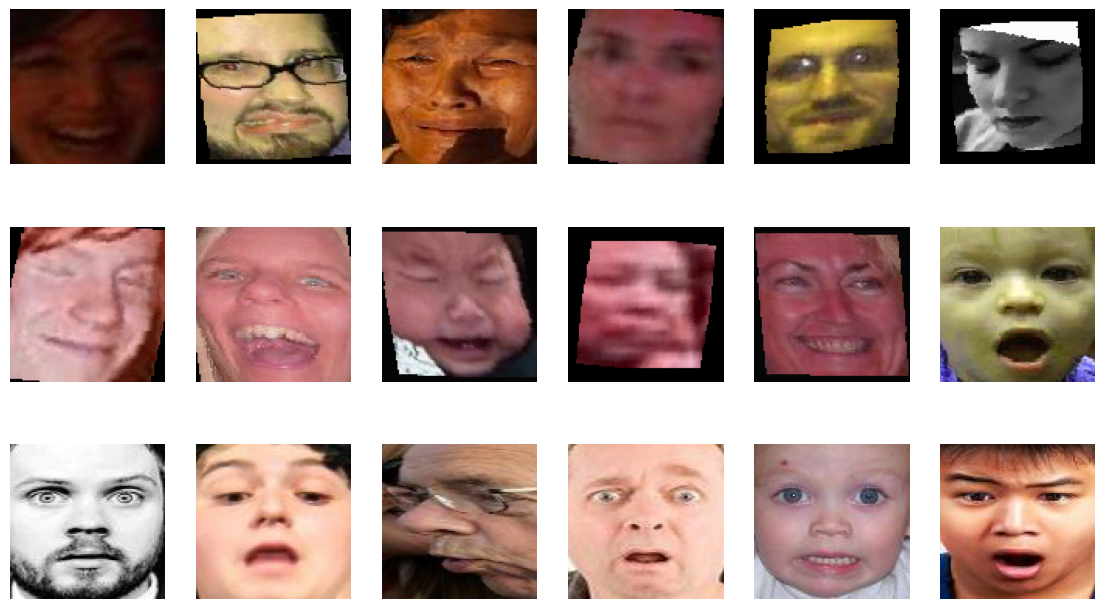

In [9]:
# Visualize the augmented data
def show_images():
    images_train, labels_train = next(iter(train_dl))
    images_val, labels_val = next(iter(val_dl))
    _, axes = plt.subplots(3, 6, figsize=(14, 8))
    axes = axes.flatten()
    for i, ax in enumerate(axes):
        if i < 12:
            # Apply the inverse normalization to the image
            img = images_train[i].permute(1, 2, 0).numpy() * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
        else:
            # Apply the inverse normalization to the image
            img = images_val[i-16].permute(1, 2, 0).numpy() * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
            
        # Clip the pixel values to be between 0 and 1
        img = np.clip(img, 0, 1)
        ax.imshow(img)
        ax.axis('off')
    plt.show()
show_images()


In [10]:
def get_old_model():
    model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
    for param in model.parameters():
        param.requires_grad = False
    model.fc = torch.nn.Linear(model.fc.in_features, 7)
    return model

def get_new_model():
    model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
    model.fc = torch.nn.Linear(model.fc.in_features, 7)
    return model
model = get_old_model()

In [82]:
import torch
from tqdm import tqdm

train_losses = []
val_losses = []
val_accuracies = []

class EarlyStopping:
    def __init__(self, patience=3, min_delta=0, restore_best_weights=False):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        self.restore_best_weights = restore_best_weights
        self.best_weights = None

    def __call__(self, val_loss, model):
        if self.best_loss is None:
            self.best_loss = val_loss
            if self.restore_best_weights:
                self.best_weights = model.state_dict()
        elif val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
            if self.restore_best_weights:
                self.best_weights = model.state_dict()
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
                if self.restore_best_weights:
                    model.load_state_dict(self.best_weights)

class CustomReduceLROnPlateau(torch.optim.lr_scheduler.ReduceLROnPlateau):
    def __init__(self, optimizer, mode='min', factor=0.1, patience=2, min_lr=1e-8, min_delta=0.01, **kwargs):
        super().__init__(optimizer, mode=mode, factor=factor, patience=patience, min_lr=min_lr, **kwargs)
        self.min_delta = min_delta # Minimum change in the monitored quantity to qualify as an improvement

    def step(self, metrics, epoch=None):
        current = float(metrics)
        if self.mode == 'min' and current > self.best - self.min_delta:
            self.num_bad_epochs += 1
        elif self.mode == 'max' and current < self.best + self.min_delta:
            self.num_bad_epochs += 1
        else:
            self.num_bad_epochs = 0
        super().step(metrics, epoch)

def evaluate_accuracy(model, data_loader):
    model.eval()
    running_corrects = 0
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            running_corrects += torch.sum(preds == labels).item()
    return running_corrects / len(data_loader.dataset)

def evaluate_recall(model, data_loader):
    model.eval()
    running_corrects = 0
    class_corrects = np.zeros(7)
    class_totals = np.zeros(7)
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            for i in range(7):
                class_corrects[i] += torch.sum((preds == labels) & (labels == i)).item()
                class_totals[i] += torch.sum(labels == i).item()
            running_corrects += torch.sum(preds == labels).item()
    return class_corrects / class_totals

def evaluate_loss(model, data_loader, criterion):
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
    return running_loss / len(data_loader)

def train_model(model, criterion, optimizer, train_loader, val_loader, early_stopping, lr_scheduler, num_epochs):
    model = model.to(device)
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        # Training phase with tqdm progress bar
        for inputs, labels in tqdm(train_loader, desc=f"[Epoch {epoch+1}/{num_epochs}]"):
            inputs, labels = inputs.to(device), labels.to(device)  # Move data to GPU

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        # Validation phase
        train_losses.append(running_loss / len(train_loader))
        val_losses.append(evaluate_loss(model, val_loader, criterion))
        val_accuracies.append(evaluate_accuracy(model, val_loader))
        
        print(f"Train Loss: {train_losses[-1]:.3f}, Val Loss: {val_losses[-1]:.3f}, Val Acc: {val_accuracies[-1]:.2f}, LR: {lr_scheduler.get_last_lr()[0]}")

        early_stopping(val_losses[-1], model)
        if early_stopping.early_stop:
            print("Early stopping...")
            break
        
        lr_scheduler.step(val_losses[-1])
        
criterion = torch.nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
lr_scheduler = CustomReduceLROnPlateau(optimizer, min_delta=0.01, patience=2, factor=0.1, min_lr=1e-8, mode='min')
early_stopping = EarlyStopping(patience=5, min_delta=0.01, restore_best_weights=True)

train_model(model, criterion, optimizer, train_dl, val_dl, early_stopping, lr_scheduler, num_epochs=10)

[Epoch 1/10]: 100%|██████████| 173/173 [00:34<00:00,  5.07it/s]


Train Loss: 1.869, Val Loss: 1.780, Val Acc: 0.32, LR: 0.001


[Epoch 2/10]: 100%|██████████| 173/173 [00:36<00:00,  4.73it/s]


Train Loss: 1.742, Val Loss: 1.922, Val Acc: 0.28, LR: 0.001


[Epoch 3/10]: 100%|██████████| 173/173 [00:41<00:00,  4.20it/s]


Train Loss: 1.705, Val Loss: 1.947, Val Acc: 0.28, LR: 0.001


[Epoch 4/10]: 100%|██████████| 173/173 [00:38<00:00,  4.53it/s]


Train Loss: 1.663, Val Loss: 1.807, Val Acc: 0.33, LR: 0.0001


[Epoch 5/10]: 100%|██████████| 173/173 [00:38<00:00,  4.45it/s]


Train Loss: 1.672, Val Loss: 1.771, Val Acc: 0.33, LR: 0.0001


[Epoch 6/10]: 100%|██████████| 173/173 [00:38<00:00,  4.52it/s]


Train Loss: 1.646, Val Loss: 1.799, Val Acc: 0.31, LR: 0.0001
Early stopping...


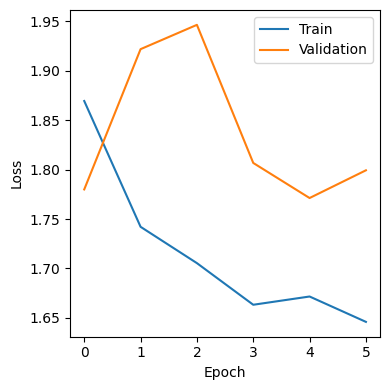

In [83]:
plt.figure(figsize=(4, 4))
plt.plot(train_losses, label='Train')
plt.plot(val_losses, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [84]:
torch.save(model.state_dict(), '..\\models\\resnet18_v1.pth')

In [85]:
# Reload the model from the saved file
model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
model.fc = torch.nn.Linear(model.fc.in_features, 7)
model.load_state_dict(torch.load('..\\models\\resnet18_v1.pth'))

for param in model.parameters():
    param.requires_grad = True
model.fc.requires_grad = True

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
lr_scheduler =  CustomReduceLROnPlateau(optimizer, min_delta=0.01, patience=2, factor=0.1, min_lr=1e-8, mode='min')
early_stopping = EarlyStopping(patience=5, min_delta=0.01, restore_best_weights=True)

# Assuming train_model is a defined function
train_model(model, criterion, optimizer, train_dl, val_dl, early_stopping, lr_scheduler, num_epochs=20)

[Epoch 1/20]: 100%|██████████| 173/173 [00:39<00:00,  4.37it/s]


Train Loss: 1.531, Val Loss: 1.290, Val Acc: 0.52, LR: 0.0001


[Epoch 2/20]: 100%|██████████| 173/173 [00:39<00:00,  4.35it/s]


Train Loss: 1.216, Val Loss: 1.040, Val Acc: 0.64, LR: 0.0001


[Epoch 3/20]: 100%|██████████| 173/173 [00:41<00:00,  4.21it/s]


Train Loss: 1.093, Val Loss: 1.088, Val Acc: 0.61, LR: 0.0001


[Epoch 4/20]: 100%|██████████| 173/173 [00:39<00:00,  4.35it/s]


Train Loss: 0.988, Val Loss: 0.945, Val Acc: 0.68, LR: 0.0001


[Epoch 5/20]: 100%|██████████| 173/173 [00:39<00:00,  4.39it/s]


Train Loss: 0.909, Val Loss: 0.976, Val Acc: 0.65, LR: 0.0001


[Epoch 6/20]: 100%|██████████| 173/173 [00:39<00:00,  4.40it/s]


Train Loss: 0.826, Val Loss: 0.895, Val Acc: 0.71, LR: 0.0001


[Epoch 7/20]: 100%|██████████| 173/173 [00:39<00:00,  4.40it/s]


Train Loss: 0.781, Val Loss: 0.844, Val Acc: 0.71, LR: 0.0001


[Epoch 8/20]: 100%|██████████| 173/173 [00:46<00:00,  3.72it/s]


Train Loss: 0.739, Val Loss: 0.867, Val Acc: 0.70, LR: 0.0001


[Epoch 9/20]: 100%|██████████| 173/173 [00:49<00:00,  3.47it/s]


Train Loss: 0.708, Val Loss: 0.858, Val Acc: 0.71, LR: 0.0001


[Epoch 10/20]: 100%|██████████| 173/173 [00:43<00:00,  3.97it/s]


Train Loss: 0.611, Val Loss: 0.788, Val Acc: 0.72, LR: 1e-05


[Epoch 11/20]: 100%|██████████| 173/173 [00:42<00:00,  4.06it/s]


Train Loss: 0.558, Val Loss: 0.760, Val Acc: 0.74, LR: 1e-05


[Epoch 12/20]: 100%|██████████| 173/173 [00:41<00:00,  4.13it/s]


Train Loss: 0.545, Val Loss: 0.748, Val Acc: 0.75, LR: 1e-05


[Epoch 13/20]: 100%|██████████| 173/173 [00:41<00:00,  4.12it/s]


Train Loss: 0.527, Val Loss: 0.725, Val Acc: 0.76, LR: 1e-05


[Epoch 14/20]: 100%|██████████| 173/173 [00:41<00:00,  4.15it/s]


Train Loss: 0.503, Val Loss: 0.748, Val Acc: 0.76, LR: 1e-05


[Epoch 15/20]: 100%|██████████| 173/173 [00:45<00:00,  3.77it/s]


Train Loss: 0.493, Val Loss: 0.743, Val Acc: 0.76, LR: 1e-05


[Epoch 16/20]: 100%|██████████| 173/173 [00:44<00:00,  3.91it/s]


Train Loss: 0.478, Val Loss: 0.724, Val Acc: 0.77, LR: 1.0000000000000002e-06


[Epoch 17/20]: 100%|██████████| 173/173 [00:46<00:00,  3.76it/s]


Train Loss: 0.475, Val Loss: 0.740, Val Acc: 0.76, LR: 1.0000000000000002e-06


[Epoch 18/20]: 100%|██████████| 173/173 [00:41<00:00,  4.19it/s]


Train Loss: 0.470, Val Loss: 0.732, Val Acc: 0.76, LR: 1.0000000000000002e-06
Early stopping...


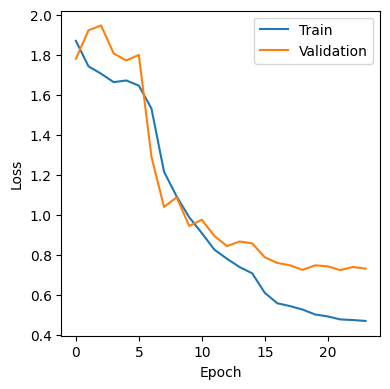

In [86]:
plt.figure(figsize=(4, 4))
plt.plot(train_losses, label='Train')
plt.plot(val_losses, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [87]:
# Save the model
torch.save(model.state_dict(), '..\\models\\resnet18_v2.pth')

In [95]:
model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
model.fc = torch.nn.Linear(model.fc.in_features, 7)
model.load_state_dict(torch.load('..\\models\\resnet18_v2.pth'))

TypeError: Expected state_dict to be dict-like, got <class 'torchvision.models.resnet.ResNet'>.

In [89]:
test_dir = '..\\data\\test' # For now
test_dataset = datasets.ImageFolder(test_dir, transform=test_transform)
test_dl = DataLoader(test_dataset, batch_size=32, shuffle=False)

model = model.to(device)
model.eval()
print("Overall test accuracy:", evaluate_accuracy(model, test_dl))
print("Per-class test recall:", evaluate_recall(model, test_dl))

Overall test accuracy: 0.7816166883963495
Per-class test recall: [0.84802432 0.64864865 0.58125    0.84810127 0.75313808 0.74691358
 0.72352941]


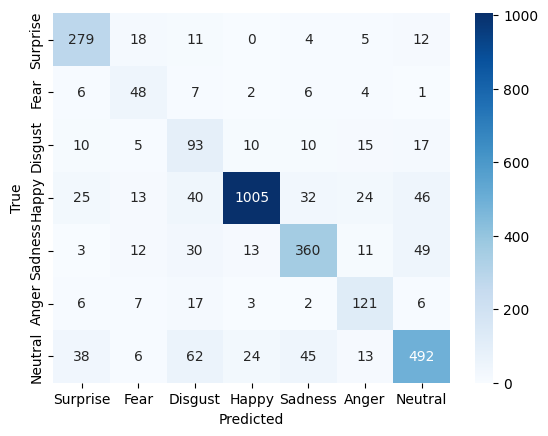

Accuracy for class Surprise: 0.85
Accuracy for class Fear: 0.65
Accuracy for class Disgust: 0.58
Accuracy for class Happy: 0.85
Accuracy for class Sadness: 0.75
Accuracy for class Anger: 0.75
Accuracy for class Neutral: 0.72


In [ ]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
def plot_confusion_matrix(model, data_loader):
    model = model.to(device)
    model.eval()
    y_true = []
    y_pred = []
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_dict.values(), yticklabels=label_dict.values())
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
    
    # Print out the accuracy for each class
    class_accuracies = cm.diagonal() / cm.sum(axis=1)
    for i, label in label_dict.items():
        print(f"Accuracy for class {label}: {class_accuracies[int(i)-1]:.2f}") 
    
plot_confusion_matrix(model, test_dl)

In [ ]:
# torch.save(model.state_dict(), '..\\models\\resnet18_weighted.pth')

In [ ]:
# Calculate the F1 score, precision, and recall
from sklearn.metrics import classification_report

def print_classification_report(model, data_loader):
    model = model.to(device)
    model.eval()
    y_true = []
    y_pred = []
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
    print(classification_report(y_true, y_pred, target_names=label_dict.values()))
    
print_classification_report(model, test_dl)

              precision    recall  f1-score   support

    Surprise       0.76      0.85      0.80       329
        Fear       0.44      0.65      0.52        74
     Disgust       0.36      0.58      0.44       160
       Happy       0.95      0.85      0.90      1185
     Sadness       0.78      0.75      0.77       478
       Anger       0.63      0.75      0.68       162
     Neutral       0.79      0.72      0.76       680

    accuracy                           0.78      3068
   macro avg       0.67      0.74      0.70      3068
weighted avg       0.81      0.78      0.79      3068

